# 4. Answering RQ4

**Can additional physiological data (monitoring the heart and skin) further improve accuracies of deep learning models for time series analysis in the predictions of task success and failure compared to the use of gaze (monitoring the eyes only)?**

---


In [ ]:
! pip install graphviz pydot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import cv2
import random
import pickle

from scipy.ndimage import gaussian_filter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Input, Concatenate, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

warnings.filterwarnings('ignore')
backend.clear_session()

In [ ]:
CECS_698_PATH = '/content/drive/MyDrive/CECS 698 - Data Analysis/'

PARTICIPANTS = [i for i in range(4, 27)]


FPOG_SCANPATHS_PATH = os.path.join(CECS_698_PATH, 'FPOG Scanpaths')

MERGED_DATA = os.path.join(CECS_698_PATH, 'Merged Data')

GOOGLE_FORMS_SHEETS = os.path.join(CECS_698_PATH, 'Google Forms Sheets')

GROUP = {
    'E-H': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 24],
    'H-E': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26]
}

# Particpants ids to exclude on specific assessments
EASY_ASSESSMENT_EXCLUDE = [11, 22]
HARD_ASSESSMENT_EXCLUDE = [15, 21]

# Size of image to store image files
IMG_SIZE=(70, 70)

# Gathering Data 📈
---

## Getting Scores

In [ ]:
df_scores = pd.read_csv(os.path.join(CECS_698_PATH, 'Participant Scores.csv'))
df_scores.head()

,Score,Participant ID,Assessment,Group,Elapsed Minutes,Successful/Unsuccessful,Python Experience,Year of Study
0,23,4,easy,E-H,10.933250,Successful,1 - 2 years,2nd Year Undergraduate
1,24,5,easy,E-H,7.933283,Successful,2 year or more,1st Year Graduate
2,26,6,easy,E-H,6.566667,Successful,1 - 2 years,3rd Year Undergraduate
3,25,7,easy,E-H,6.249933,Successful,1 - 2 years,3rd Year Undergraduate
4,20,8,easy,E-H,7.866567,Unsuccessful,1 - 2 years,3rd Year Undergraduate


In [ ]:
label_counts = {'Successful': 0, 'Unsuccessful': 0}
for label in df_scores['Successful/Unsuccessful']:
    label_counts[label] += 1

print(f"{label_counts} (Proportion successful: {(label_counts['Successful'] / len(df_scores)):.2f}, Proportion unsuccessful: {(label_counts['Unsuccessful'] / len(df_scores)):.2f})")

{'Successful': 22, 'Unsuccessful': 20} (Proportion successful: 0.52, Proportion unsuccessful: 0.48)


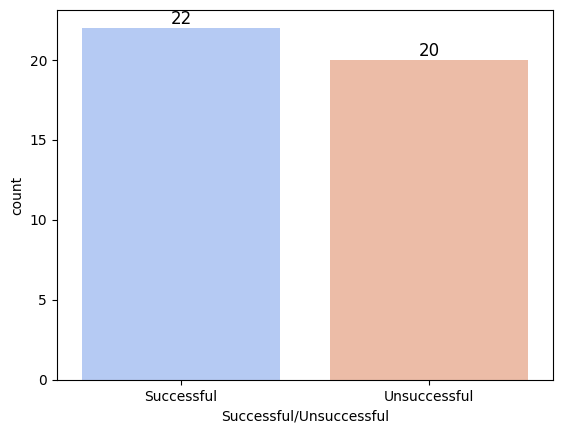

In [ ]:
ax = sns.countplot(data=df_scores, x='Successful/Unsuccessful', palette='coolwarm')

# Add labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Convert count to an integer
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position label at the top
                ha='center', va='bottom',  # Center alignment
                fontsize=12)

# Show the plot
plt.show()

## Combining Questionnaire Data

In [ ]:
# ----------------------------------------------- NASA TLX -----------------------------------------------
df_NASA_TLX = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - NASA TLX.csv'))#.drop('Dry Run?', axis=1)

df_NASA_TLX.columns = [
    'Timestamp',
    'Participant ID',
    'Mental Demand', # 1
    'Physical Demand', # 2
    'Temporal Demand', # 3
    'Performance', # 4
    'Effort', # 5
    'Frustration', # 6
    'Dry Run', # 7
]

df_NASA_TLX = df_NASA_TLX[df_NASA_TLX['Dry Run'].isnull()] # Take out dry run participants
df_NASA_TLX.drop(['Dry Run', 'Timestamp'], axis=1, inplace=True)


# ----------------------------------------------- Pre-Study KSS -----------------------------------------------
df_pre_study_KSS = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Pre-Study KSS.csv'))
df_pre_study_KSS = df_pre_study_KSS[df_pre_study_KSS['Dry Run?'].isnull()]
df_pre_study_KSS.drop(['Dry Run?', 'Timestamp'], axis=1, inplace=True)
df_pre_study_KSS.columns = [
    'Participant ID',
    'Hours Awake',
    'Pre-Sleepiness Scale',
]
df_pre_study_KSS['Pre-Sleepiness Scale'] = df_pre_study_KSS['Pre-Sleepiness Scale'].apply(lambda x: int(x.split()[0]))


# ----------------------------------------------- Post-Study KSS -----------------------------------------------
df_post_study_KSS = pd.read_csv(os.path.join(GOOGLE_FORMS_SHEETS, 'Participants Sheet - Post-Study KSS.csv'))
df_post_study_KSS = df_post_study_KSS[df_post_study_KSS['Dry Run?'].isnull()]
df_post_study_KSS.drop(['Dry Run?', 'Timestamp'], axis=1, inplace=True)
df_post_study_KSS.columns = [
    'Participant ID',
    'Post-Sleepiness Scale',
]
df_post_study_KSS['Post-Sleepiness Scale'] = df_post_study_KSS['Post-Sleepiness Scale'].apply(lambda x: int(x.split()[0]))

df_all_questionnaires = df_NASA_TLX.merge(df_pre_study_KSS, on='Participant ID', how='inner').merge(df_post_study_KSS, on='Participant ID', how='inner')
df_all_questionnaires = df_all_questionnaires.merge(df_scores, left_on='Participant ID', right_on='Participant ID ').drop(columns=['Participant ID '])
df_all_questionnaires.head()

,Participant ID,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,Hours Awake,Pre-Sleepiness Scale,Post-Sleepiness Scale,Score,Assessment,Group,Elapsed Minutes,Successful/Unsuccessful,Python Experience,Year of Study
0,4,6,7,1,7,5,3,7.0,8,2,23,easy,E-H,10.933250,Successful,1 - 2 years,2nd Year Undergraduate
1,4,6,7,1,7,5,3,7.0,8,2,24,hard,E-H,26.266650,Successful,1 - 2 years,2nd Year Undergraduate
2,5,6,1,2,4,5,6,3.0,7,7,24,easy,E-H,7.933283,Successful,2 year or more,1st Year Graduate
3,5,6,1,2,4,5,6,3.0,7,7,24,hard,E-H,26.933333,Successful,2 year or more,1st Year Graduate
4,6,3,5,2,6,4,2,7.0,5,7,26,easy,E-H,6.566667,Successful,1 - 2 years,3rd Year Undergraduate


In [ ]:
df_all_questionnaires.columns

Index(['Participant ID', 'Mental Demand', 'Physical Demand', 'Temporal Demand',
       'Performance', 'Effort', 'Frustration', 'Hours Awake',
       'Pre-Sleepiness Scale', 'Post-Sleepiness Scale', 'Score', 'Assessment',
       'Group', 'Elapsed Minutes', 'Successful/Unsuccessful',
       'Python Experience', 'Year of Study'],
      dtype='object')

## Get X, y data then `train_test_split`

In [ ]:
def read_y_labels(path):
    y = []
    for p in PARTICIPANTS:
        for diff in ['easy', 'hard']:
            if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
                continue # Excluded assessments (i.e ones with data loss)

            label = df_scores[(df_scores['Participant ID '] == p) & (df_scores['Assessment'] == diff)]['Successful/Unsuccessful'].values[0]
            label = 1 if label == 'Successful' else 0
            y.append(label)

    y = np.array(y)

    return y

def read_X_timeseries(path):
    X = []
    for p in PARTICIPANTS:
        for diff in ['easy', 'hard']:
            if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
                continue # Excluded assessments (i.e ones with data loss)

            folder = f"Participant {p}"
            file = f"participant{p}_{diff}_assessment.csv"

            # Merged data path
            df = pd.read_csv(os.path.join(path, folder, file))
            df.set_index('timestamp_unix', inplace=True)
            # df['Participant ID'] = p
            # df['Assessment'] = diff

            # Synthetic data path
            X.append(df)

    return X

def read_X_categorical(path):
    # Getting all dataframes and splitting them into 2 groups: Successful and Unsuccessful
    X = pd.DataFrame()

    features = ['Participant ID', 'Mental Demand', 'Physical Demand', 'Temporal Demand',
       'Performance', 'Effort', 'Frustration', 'Hours Awake',
       'Pre-Sleepiness Scale', 'Post-Sleepiness Scale', 'Assessment',
       'Group', 'Elapsed Minutes',
       'Python Experience', 'Year of Study']

    for p in PARTICIPANTS:
        for diff in ['easy', 'hard']:
            if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
                continue # Excluded assessments (i.e ones with data loss)

            filter = (df_all_questionnaires['Participant ID'] == p) & (df_all_questionnaires['Assessment'] == diff)
            df_participant = df_all_questionnaires[filter]

            X = pd.concat([X, df_participant[features]], axis=0)

    return X


# Helper function to read a single image
def read_image(img_path, img_size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size) # Resizing all images to make them uniform
    img = img.astype("float32") / 255.0  # Normalize
    return img

def read_X_image(path, img_size=IMG_SIZE):
    X = []

    for p in PARTICIPANTS:
        for diff in ['easy', 'hard']:
            if (diff == 'easy' and p in EASY_ASSESSMENT_EXCLUDE) or (diff == 'hard' and p in HARD_ASSESSMENT_EXCLUDE):
                continue # Excluded assessments (i.e ones with data loss)

            folder = f"Participant {p}"
            file = f"FPOG {diff}.png"

            # Reading in each image
            img_path = os.path.join(path, folder, file)
            img = read_image(img_path, img_size)
            X.append(img)

    X = np.array(X)
    return X

Train test splitting

In [ ]:
X_timeseries = read_X_timeseries(MERGED_DATA)
X_categorical = read_X_categorical(MERGED_DATA)
X_image = read_X_image(FPOG_SCANPATHS_PATH)
y = read_y_labels(MERGED_DATA)

print(f"X_timeseries: {len(X_timeseries)}, X_categorical: {len(X_categorical)}, X_image: {len(X_image)}, y_actual: {len(y)}")

X_timeseries_train, X_timeseries_test, \
X_categorical_train, X_categorical_test, \
X_image_train, X_image_test, \
y_train, y_test = train_test_split(
    X_timeseries, X_categorical, X_image, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

X_timeseries: 42, X_categorical: 42, X_image: 42, y_actual: 42


In [ ]:
def get_split_info(df):
    label_counts = {'Successful': 0, 'Unsuccessful': 0}
    participants_list, assessment_list = [], []

    for idx, row in df.iterrows():
        participant_id, assessment = row['Participant ID'], row['Assessment']
        participants_list.append(participant_id)
        assessment_list.append(assessment)

        label = df_scores[(df_scores['Participant ID '] == participant_id) & (df_scores['Assessment'] == assessment)]['Successful/Unsuccessful'].values[0]
        label_counts[label] += 1
        print(f"Participant {participant_id} ({assessment} assessment) - {label}")

    total = len(df)
    print(f"{label_counts} (Proportion successful: {(label_counts['Successful'] / total):.2f}, Proportion unsuccessful: {(label_counts['Unsuccessful'] / total):.2f})")

    return participants_list, assessment_list

Valdiating train and test data (Are they correctly split?)

In [ ]:
print(f'---------- TRAINING DATA ({len(X_categorical_train)}) ----------')
participant_id_train, assessment_train = get_split_info(X_categorical_train)

print()

print(f'---------- TEST DATA ({len(X_categorical_test)}) ----------')
label_counts = {'Successful': 0, 'Unsuccessful': 0}
participant_id_test, assessment_test = get_split_info(X_categorical_test)

---------- TRAINING DATA (25) ----------
Participant 19 (easy assessment) - Unsuccessful
Participant 21 (easy assessment) - Unsuccessful
Participant 14 (easy assessment) - Unsuccessful
Participant 6 (easy assessment) - Successful
Participant 12 (easy assessment) - Unsuccessful
Participant 5 (hard assessment) - Successful
Participant 25 (hard assessment) - Successful
Participant 9 (easy assessment) - Successful
Participant 7 (easy assessment) - Successful
Participant 7 (hard assessment) - Unsuccessful
Participant 20 (easy assessment) - Unsuccessful
Participant 10 (easy assessment) - Unsuccessful
Participant 26 (hard assessment) - Successful
Participant 6 (hard assessment) - Successful
Participant 16 (easy assessment) - Successful
Participant 8 (hard assessment) - Unsuccessful
Participant 9 (hard assessment) - Successful
Participant 22 (hard assessment) - Unsuccessful
Participant 23 (hard assessment) - Successful
Participant 5 (easy assessment) - Successful
Participant 16 (hard assessmen

# Data Preprocessing 🏭
---

## Preprocess timeseries data

In [ ]:
# Normalize each participant's DataFrame individually.
def scale_timeseries_data(X):
    X_scaled = []

    for df in X:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df.values)
        # Create a new DataFrame to hold the scaled values
        scaled_df = pd.DataFrame(scaled_values, columns=df.columns)
        X_scaled.append(scaled_df)

    return X_scaled

In [ ]:
X_timeseries_train = scale_timeseries_data(X_timeseries_train)
X_timeseries_test = scale_timeseries_data(X_timeseries_test)

All time series are different lengths. We must use padding to have them the same lengths

In [ ]:
max_seq_length = 0

for sequence in X_timeseries_train + X_timeseries_test:
    max_seq_length = max(max_seq_length, len(sequence))

print(f"Padding with max sequence length: {max_seq_length}")


# Pad sequences to the max length (Expected: 248)
X_timeseries_train = pad_sequences(X_timeseries_train, maxlen=max_seq_length, padding='post', dtype='float32')
X_timeseries_test = pad_sequences(X_timeseries_test, maxlen=max_seq_length, padding='post', dtype='float32')

Padding with max sequence length: 248


## Preprocess categorical data

In [ ]:
X_categorical_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 28 to 36
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Participant ID         25 non-null     int64  
 1   Mental Demand          25 non-null     int64  
 2   Physical Demand        25 non-null     int64  
 3   Temporal Demand        25 non-null     int64  
 4   Performance            25 non-null     int64  
 5   Effort                 25 non-null     int64  
 6   Frustration            25 non-null     int64  
 7   Hours Awake            25 non-null     float64
 8   Pre-Sleepiness Scale   25 non-null     int64  
 9   Post-Sleepiness Scale  25 non-null     int64  
 10  Assessment             25 non-null     object 
 11  Group                  25 non-null     object 
 12  Elapsed Minutes        25 non-null     float64
 13  Python Experience      25 non-null     object 
 14  Year of Study          25 non-null     object 
dtypes: float64(2

One Hot Encoding of Nominal variables: `Group` and `Year of Study`

In [ ]:
# We can change the `Year of Study` feature to divide between undergrad and graduate students strictly.
X_categorical_train['Year of Study'] = X_categorical_train['Year of Study'].apply(lambda x: 'Undergrad' if 'Undergrad' in x else 'Grad')
X_categorical_test['Year of Study'] = X_categorical_test['Year of Study'].apply(lambda x: 'Undergrad' if 'Undergrad' in x else 'Grad')

In [ ]:
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # `drop=first` to prevent multicollinearity

# Fit and transform the data
train_encoded = encoder.fit_transform(X_categorical_train[['Year of Study', 'Assessment']])
test_encoded = encoder.transform(X_categorical_test[['Year of Study', 'Assessment']])

# Convert to DataFrame with column names
train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(['Year of Study', 'Assessment']))
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(['Year of Study', 'Assessment']))

# Resetting columns to
X_categorical_train.reset_index(drop=True, inplace=True)
X_categorical_test.reset_index(drop=True, inplace=True)

# Drop original categorical columns and concatenate with encoded features
X_categorical_train = pd.concat([X_categorical_train.drop(columns=['Year of Study', 'Assessment']), train_encoded_df], axis=1)
X_categorical_test = pd.concat([X_categorical_test.drop(columns=['Year of Study', 'Assessment']), test_encoded_df], axis=1)

In [ ]:
# Dropping irrelevant columns from categorical data
X_categorical_train.drop(columns=['Group', 'Participant ID'], inplace=True)
X_categorical_train.reset_index(drop=True, inplace=True)

X_categorical_test.drop(columns=['Group', 'Participant ID'], inplace=True)
X_categorical_test.reset_index(drop=True, inplace=True)

X_categorical_train.shape, X_categorical_test.shape

((25, 13), (17, 13))

Scaling numerical columns:
`Mental Demand`,
`Physical Demand`,
`Temporal Demand`,
`Performance`,
`Effort`,
`Frustration`,
`Hours Awake`,
`Elapsed Minutes`,
`Pre-Sleepiness Scale`,
`Post-Sleepiness Scale`

In [ ]:
scaler = MinMaxScaler()
numerical_columns = [
    'Mental Demand',
    'Physical Demand',
    'Temporal Demand',
    'Performance',
    'Effort',
    'Frustration',
    'Hours Awake',
    'Elapsed Minutes',
    'Pre-Sleepiness Scale',
    'Post-Sleepiness Scale'
]

X_categorical_train[numerical_columns] = scaler.fit_transform(X_categorical_train[numerical_columns])
X_categorical_test[numerical_columns] = scaler.transform(X_categorical_test[numerical_columns])

Ordinal Encoding of Ordinal variables: `Python Experience`

In [ ]:
experience_level = list(X_categorical_train['Python Experience'].unique())
experience_level

['Less than 1 year', '1 - 2 years', '2 year or more']

In [ ]:
encoder = OrdinalEncoder(categories=[experience_level])

X_categorical_train[['Python Experience']] = encoder.fit_transform(X_categorical_train[['Python Experience']])
X_categorical_test[['Python Experience']] = encoder.transform(X_categorical_test[['Python Experience']])

In [ ]:
X_categorical_train.shape, X_categorical_test.shape

((25, 13), (17, 13))

In [ ]:
X_categorical_train#.head()

,Mental Demand,Physical Demand,Temporal Demand,Performance,Effort,Frustration,Hours Awake,Pre-Sleepiness Scale,Post-Sleepiness Scale,Elapsed Minutes,Python Experience,Year of Study_Undergrad,Assessment_hard
0,0.666667,0.25,0.6,0.50,0.25,0.2,0.428571,1.000000,0.666667,0.000000,0.0,1.0,0.0
1,0.666667,0.25,0.4,0.75,0.25,0.2,0.238095,0.500000,0.333333,0.135387,0.0,1.0,0.0
2,0.000000,0.25,0.6,1.00,0.00,0.0,0.238095,0.333333,0.500000,0.141778,0.0,1.0,0.0
3,0.000000,1.00,0.2,0.75,0.50,0.2,0.428571,0.333333,0.833333,0.068566,1.0,1.0,0.0
4,0.666667,0.25,0.2,0.75,1.00,0.0,0.238095,0.000000,0.166667,0.156574,0.0,1.0,0.0
5,1.000000,0.00,0.2,0.25,0.75,1.0,0.047619,0.666667,0.833333,0.778620,2.0,0.0,1.0
6,0.333333,0.50,0.4,0.25,0.25,0.2,0.904762,0.500000,0.333333,0.750729,2.0,0.0,1.0
7,0.333333,0.50,0.4,0.25,0.25,0.2,0.619048,0.666667,1.000000,0.040090,0.0,1.0,0.0
8,0.666667,0.00,0.6,0.50,0.50,0.4,0.000000,0.500000,0.333333,0.057523,1.0,1.0,0.0
9,0.666667,0.00,0.6,0.50,0.50,0.4,0.000000,0.500000,0.333333,0.355025,1.0,1.0,1.0


## Preprocess Image Data

Rearranging the shape of train and test datasets to have one more dimension at the end representing color channels:

(Number of Images x Height x Width x Color Channels)

In [ ]:
X_image_train.shape, X_image_test.shape

((25, 70, 70), (17, 70, 70))

In [ ]:
X_image_train = np.expand_dims(X_image_train, axis=-1)
X_image_test = np.expand_dims(X_image_test, axis=-1)

X_image_train.shape, X_image_test.shape

((25, 70, 70, 1), (17, 70, 70, 1))

# Model Training: Eye Tracking and Physiological Biomarkers 🫀👁️

---

Helper functions

In [ ]:
def plot_history(history):
    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot Accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].legend()

    # Plot Loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss')
    axes[1].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

def evaluate_test_predictions(model, X_input):
    # ---------- Get best test accuracy ----------
    test_loss, test_acc = model.evaluate(X_input, y_test)
    print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    # ---------- Evaluate indiviudal predictions ----------
    predictions = (model.predict(X_input) > 0.5).astype(int)
    print(classification_report(y_test, predictions))

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix using Seaborn
    plt.figure(figsize=(4, 2))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

In [ ]:
saved_models = os.path.join(CECS_698_PATH, 'Saved Models')
if not os.path.exists(saved_models):
    os.makedirs(saved_models)
    print(f"Created {saved_models}")
else:
    print(f"{saved_models} already exists")

model_history = os.path.join(saved_models, 'Model History')
if not os.path.exists(model_history):
    os.makedirs(model_history)
    print(f"Created {model_history}")
else:
    print(f"{model_history} already exists")

/content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models already exists
/content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models/Model History already exists


## Single Modal: Timeseries

In [ ]:
num_features = X_timeseries_train.shape[2]

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(max_seq_length, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 248, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 248, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,985 (179.63 KB)

 Trainable params: 45,985 (179.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filename = 'one-modal-ts' # One modal timeseries
one_modal_path = os.path.join(saved_models, f"{filename}.h5")
one_modal_history = os.path.join(model_history, f"{filename}.pkl")

# If this model exists, don't do any more traing
if os.path.exists(one_modal_path) and os.path.exists(one_modal_history):
    print(f"Model already exists")
else:
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    checkpoint_callback = ModelCheckpoint(
        filepath=one_modal_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the Model
    history = model.fit(X_timeseries_train, y_train, epochs=500, batch_size=8, callbacks=[early_stop, checkpoint_callback], validation_data=(X_timeseries_test, y_test))

    # Save history
    with open(one_modal_history, 'wb') as f:
        pickle.dump(history, f)

Model already exists


In [ ]:
# Load model (With best parameters for maximal accuracy)
model = load_model(one_modal_path)

# Load model history
with open(one_modal_history, 'rb') as f:
    history = pickle.load(f)

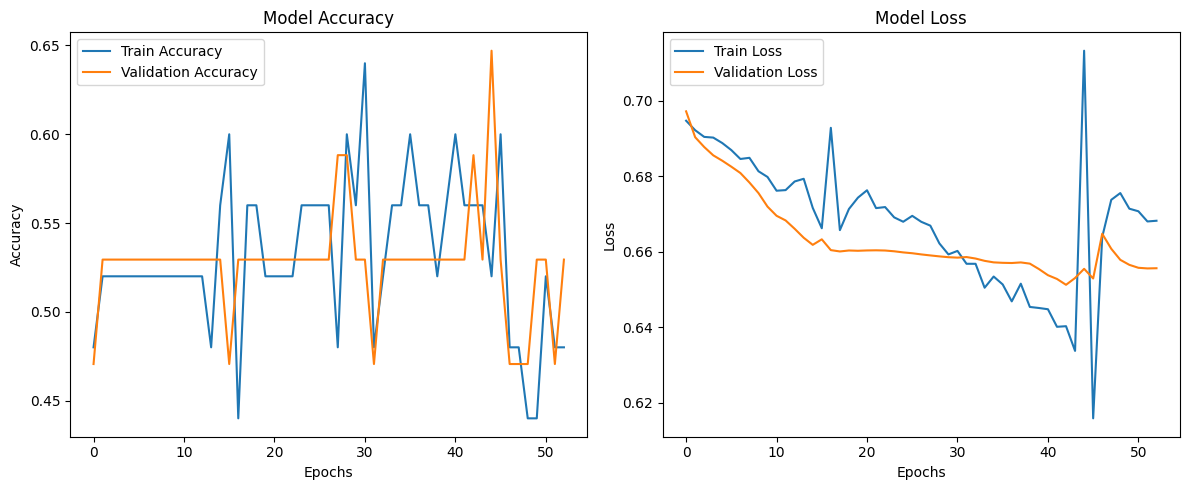

In [ ]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6471 - loss: 0.6555
Test Accuracy: 0.6471, Test Loss: 0.6555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.64      0.78      0.70         9

    accuracy                           0.65        17
   macro avg       0.65      0.64      0.64        17
weighted avg       0.65      0.65      0.64        17



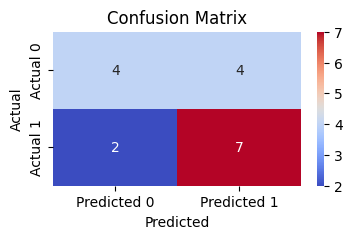

In [ ]:
evaluate_test_predictions(model, [X_timeseries_test])

## 2-Modal: Timeseries + Questionnaires

In [ ]:
# Time Series Input (LSTM)
num_timeseries_features = X_timeseries_train.shape[2]
time_input = Input(shape=(None, num_timeseries_features), name="Time_Series_Input")
ts = LSTM(64, return_sequences=True)(time_input)
ts = Dropout(0.2)(ts)
ts = LSTM(32, return_sequences=False)(ts)
ts = Dropout(0.2)(ts)
ts = Dense(16, activation='relu')(ts)

## Questionnaire Input (Dense)
num_questionnaire_features = X_categorical_train.shape[1]
questionnaire_input = Input(shape=(num_questionnaire_features,), name='Questionnaire_Input')
q = Dense(64, activation='relu')(questionnaire_input)
q = Dropout(0.2)(q)
q = Dense(32, activation='relu')(q)
q = Dropout(0.2)(q)
q = Dense(16, activation='relu')(q)

## Merge all inputs
merged = Concatenate()([ts, q])
output = Dense(1, activation='sigmoid', name="Output")(merged)

# Define model
model = Model(inputs=[time_input, questionnaire_input], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Time_Series_Input         │ (None, None, 64)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Questionnaire_Input       │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, None, 64)       │         33,024 │ Time_Series_Input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │            896 │ Questionnaire_Input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, None, 64)       │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 32)             │         12,416 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │            528 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16)             │            528 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32)             │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 1)              │             33 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 49,505 (193.38 KB)

 Trainable params: 49,505 (193.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filename = 'two-modal-ts-q' # Two modal timeseries and questionnaires
two_modal_path = os.path.join(saved_models, f"{filename}.h5")
two_modal_history = os.path.join(model_history, f"{filename}.pkl")

# If this model exists, don't do any more traing
if os.path.exists(two_modal_path) and os.path.exists(two_modal_history):
    print(f"Model already exists")
else:
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    checkpoint_callback = ModelCheckpoint(
        filepath=two_modal_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the Model
    history = model.fit(
        [X_timeseries_train, X_categorical_train], y_train,
        epochs=500,
        batch_size=8,
        validation_data=([X_timeseries_test, X_categorical_test], y_test),
        callbacks=[early_stop, checkpoint_callback]
    )

    # Save history
    with open(two_modal_history, 'wb') as f:
        pickle.dump(history, f)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.5250 - loss: 0.7164
Epoch 1: val_accuracy improved from -inf to 0.52941, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models/two-modal-ts-q.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.5400 - loss: 0.7136 - val_accuracy: 0.5294 - val_loss: 0.6753
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5158 - loss: 0.6808
Epoch 2: val_accuracy improved from 0.52941 to 0.58824, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models/two-modal-ts-q.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 352ms/step - accuracy: 0.5087 - loss: 0.6830 - val_accuracy: 0.5882 - val_loss: 0.6755
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4217 - loss: 0.7149
Epoch 3: val_accuracy did not improve from 0.58824
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.4413 - loss: 0.7123 - val_accuracy: 0.5882 - val_loss: 0.6723
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5671 - loss: 0.6911
Epoch 4: val_accuracy did not improve from 0.58824
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.5657 - loss: 0.6896 - val_accuracy: 0.5882 - val_loss: 0.6683
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5675 - loss: 0.6723
Epoch 5: val_accuracy improved from 0.58824 to 0.64706, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models/two-modal-ts-q.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.5580 - loss: 0.6747 - val_accuracy: 0.6471 - val_loss: 0.6638
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6283 - loss: 0.6759
Epoch 6: val_accuracy did not improve from 0.64706
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.6387 - loss: 0.6749 - val_accuracy: 0.6471 - val_loss: 0.6596
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6031 - loss: 0.6676
Epoch 7: val_accuracy did not improve from 0.64706
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.6025 - loss: 0.6676 - val_accuracy: 0.6471 - val_loss: 0.6550
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.4890 - loss: 0.6873
Epoch 8: val_accuracy did not improve from 0.64706
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.5032 - loss: 0.6843 - val_accuracy: 0.6471 - val_loss: 0.6519
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6179 - loss: 0.6680
Epoch 9: val_accuracy improved from 0.64706 to 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.6303 - loss: 0.6658 - val_accuracy: 0.7059 - val_loss: 0.6478
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5875 - loss: 0.6426
Epoch 10: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.5900 - loss: 0.6446 - val_accuracy: 0.7059 - val_loss: 0.6443
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6287 - loss: 0.6465
Epoch 11: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.6310 - loss: 0.6489 - val_accuracy: 0.7059 - val_loss: 0.6422
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6852 - loss: 0.6608
Epoch 12: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.6922 - loss: 0.6588 - val_accuracy: 0.6471 - val_loss: 0.6408
Epoch 13/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7633 - loss: 0.6495
Epoch 13: val_accuracy did not improve f

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step - accuracy: 0.8283 - loss: 0.5684 - val_accuracy: 0.7647 - val_loss: 0.5969
Epoch 32/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6383 - loss: 0.6350
Epoch 32: val_accuracy did not improve from 0.76471
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.6547 - loss: 0.6281 - val_accuracy: 0.7647 - val_loss: 0.5943
Epoch 33/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8715 - loss: 0.5103
Epoch 33: val_accuracy did not improve from 0.76471
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.8652 - loss: 0.5142 - val_accuracy: 0.7647 - val_loss: 0.5910
Epoch 34/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8450 - loss: 0.5169
Epoch 34: val_accuracy did not improve from 0.76471
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.8520 - loss: 0.5160 - val_accuracy: 0.7647 - val_loss: 0.5866
Epoch 35/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7885 - loss: 0.5718
Epoch 35: val_accuracy did not improve f

In [ ]:
# Load model (With best parameters for maximal accuracy)
model = load_model(two_modal_path)

# Load model history
with open(two_modal_history, 'rb') as f:
    history = pickle.load(f)

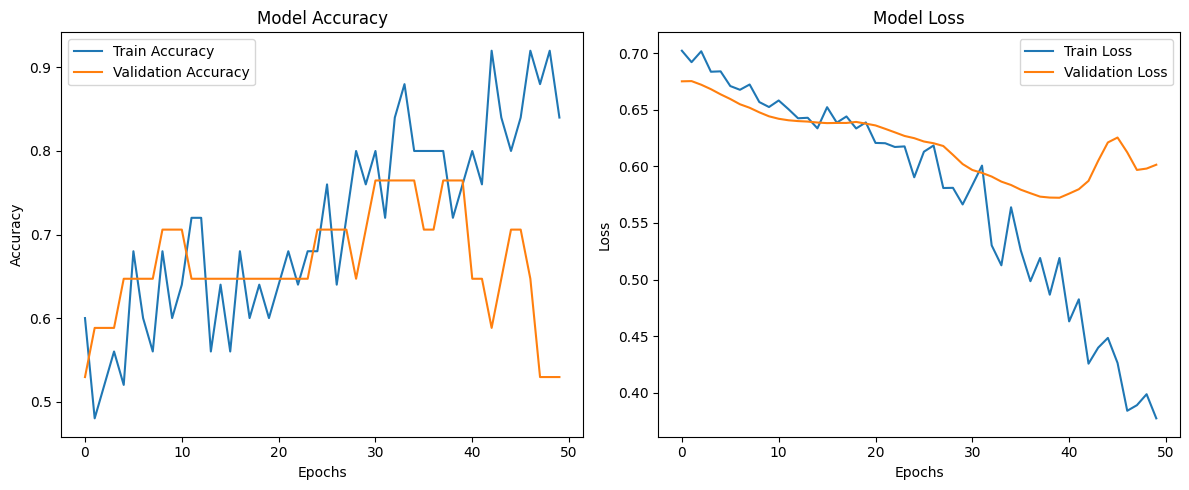

In [ ]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7647 - loss: 0.5969
Test Accuracy: 0.7647, Test Loss: 0.5969
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.86      0.67      0.75         9

    accuracy                           0.76        17
   macro avg       0.78      0.77      0.76        17
weighted avg       0.78      0.76      0.76        17



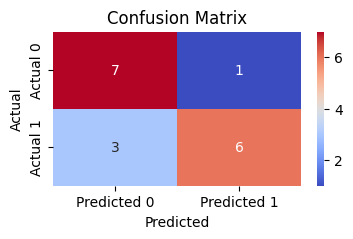

In [ ]:
evaluate_test_predictions(model, [X_timeseries_test, X_categorical_test])

## 2-Modal: Timeseries + Images

In [ ]:
# Time Series Input (LSTM)
num_timeseries_features = X_timeseries_train.shape[2]
time_input = Input(shape=(None, num_timeseries_features), name="Time_Series_Input")
ts = LSTM(64, return_sequences=True)(time_input)
ts = Dropout(0.2)(ts)
ts = LSTM(32, return_sequences=False)(ts)
ts = Dropout(0.2)(ts)
ts = Dense(16, activation='relu')(ts)

# Image Input (CNN)
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)
image_input = Input(shape=input_shape, name="Image_Input")
img = Conv2D(64, (3, 3), activation='relu')(image_input)
img = MaxPooling2D((2, 2))(img)
img = Conv2D(32, (3, 3), activation='relu')(img)
img = MaxPooling2D((2, 2))(img)
img = Conv2D(16, (3, 3), activation='relu')(img)
img = MaxPooling2D((2, 2))(img)
img = Flatten()(img)
img = Dense(64, activation='relu')(img)

## Merge all inputs
merged = Concatenate()([ts, img])
output = Dense(1, activation='sigmoid', name="Output")(merged)

# Define model
model = Model(inputs=[time_input, image_input], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 70, 70, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 68, 68, 64)     │            640 │ Image_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 34, 34, 64)     │              0 │ conv2d_6[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Time_Series_Input         │ (None, None, 64)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 32)     │         18,464 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ (None, None, 64)       │         33,024 │ Time_Series_Input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 32)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, None, 64)       │              0 │ lstm_8[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 16)     │          4,624 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ (None, 32)             │         12,416 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 7, 7, 16)       │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 32)             │              0 │ lstm_9[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 784)            │              0 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 16)             │            528 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 64)             │         50,240 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 80)             │              0 │ dense_13[0][0],        │
│ (Concatenate)             │                        │                │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 1)              │             81 │ concatenate_3[0][0]    │
└──────────────────────

 Total params: 120,017 (468.82 KB)

 Trainable params: 120,017 (468.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
filename = 'two-modal-ts-img' # Two modal timeseries and images
two_modal_path2 = os.path.join(saved_models, f"{filename}.h5")
two_modal_history2 = os.path.join(model_history, f"{filename}.pkl")

# If this model exists, don't do any more traing
if os.path.exists(two_modal_path2) and os.path.exists(two_modal_history2):
    print(f"Model already exists")
else:
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    checkpoint_callback = ModelCheckpoint(
        filepath=two_modal_path2,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the Model
    history = model.fit(
        [X_timeseries_train, X_image_train], y_train,
        epochs=500,
        batch_size=8,
        validation_data=([X_timeseries_test, X_image_test], y_test),
        callbacks=[early_stop, checkpoint_callback]
    )

    # Save history
    with open(two_modal_history2, 'wb') as f:
        pickle.dump(history, f)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.4329 - loss: 0.7043
Epoch 1: val_accuracy improved from -inf to 0.52941, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models/two-modal-ts-img.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 461ms/step - accuracy: 0.4343 - loss: 0.7043 - val_accuracy: 0.5294 - val_loss: 0.6776
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5154 - loss: 0.6453
Epoch 2: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.5163 - loss: 0.6466 - val_accuracy: 0.5294 - val_loss: 0.6768
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.4677 - loss: 0.6833
Epoch 3: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.4942 - loss: 0.6737 - val_accuracy: 0.5294 - val_loss: 0.6642
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7321 - loss: 0.5981
Epoch 4: val_accuracy did not improve from 0.52941
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 387ms/step - accuracy: 0.7297 - loss: 0.5963 - val_accuracy: 0.5294 - val_loss: 0.6662
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7056 - loss: 0.5600
Epoch 5: val_accuracy did not improve from 0.52

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.7012 - loss: 0.5143 - val_accuracy: 0.5882 - val_loss: 0.7527
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8606 - loss: 0.3972
Epoch 7: val_accuracy improved from 0.58824 to 0.64706, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models/two-modal-ts-img.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.8645 - loss: 0.3990 - val_accuracy: 0.6471 - val_loss: 0.6478
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.8715 - loss: 0.3539
Epoch 8: val_accuracy improved from 0.64706 to 0.70588, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models/two-modal-ts-img.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.8652 - loss: 0.3609 - val_accuracy: 0.7059 - val_loss: 0.6657
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8763 - loss: 0.3590
Epoch 9: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8770 - loss: 0.3572 - val_accuracy: 0.6471 - val_loss: 0.6732
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9640 - loss: 0.2739
Epoch 10: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9632 - loss: 0.2691 - val_accuracy: 0.6471 - val_loss: 0.7025
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9327 - loss: 0.2078
Epoch 11: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9382 - loss: 0.1988 - val_accuracy: 0.5294 - val_loss: 0.8473
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9327 - loss: 0.1526
Epoch 12: val_accuracy did not improve fro

In [ ]:
# Load model (With best parameters for maximal accuracy)
model = load_model(two_modal_path2)

# Load model history
with open(two_modal_history2, 'rb') as f:
    history = pickle.load(f)

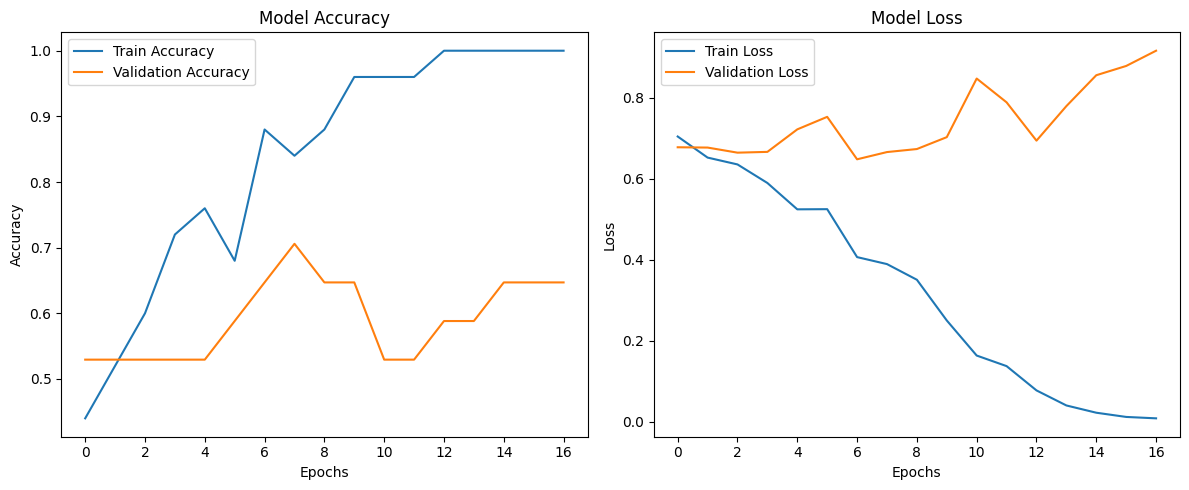

In [ ]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7059 - loss: 0.6657
Test Accuracy: 0.7059, Test Loss: 0.6657
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.75      0.67      0.71         9

    accuracy                           0.71        17
   macro avg       0.71      0.71      0.71        17
weighted avg       0.71      0.71      0.71        17



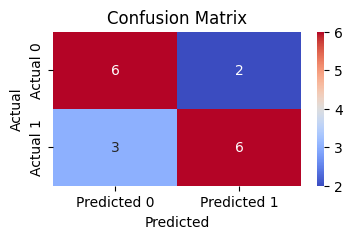

In [ ]:
evaluate_test_predictions(model, [X_timeseries_test, X_image_test])

## 3-Modal: Timeseries + Questionnaires + Images

In [ ]:
# Time Series Input (LSTM)
num_timeseries_features = X_timeseries_train.shape[2]
time_input = Input(shape=(None, num_timeseries_features), name="Time_Series_Input")
ts = LSTM(64, return_sequences=True)(time_input)
ts = Dropout(0.2)(ts)
ts = LSTM(32, return_sequences=False)(ts)
ts = Dropout(0.2)(ts)
ts = Dense(16, activation='relu')(ts)

## Questionnaire Input (Dense)
num_questionnaire_features = X_categorical_train.shape[1]
questionnaire_input = Input(shape=(num_questionnaire_features,), name='Questionnaire_Input')
q = Dense(64, activation='relu')(questionnaire_input)
q = Dropout(0.2)(q)
q = Dense(32, activation='relu')(q)
q = Dropout(0.2)(q)
q = Dense(16, activation='relu')(q)

# Image Input (CNN)
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)
image_input = Input(shape=input_shape, name="Image_Input")
img = Conv2D(64, (3, 3), activation='relu')(image_input)
img = MaxPooling2D((2, 2))(img)
img = Conv2D(32, (3, 3), activation='relu')(img)
img = MaxPooling2D((2, 2))(img)
img = Conv2D(16, (3, 3), activation='relu')(img)
img = MaxPooling2D((2, 2))(img)
img = Flatten()(img)
img = Dense(64, activation='relu')(img)

## Merge all inputs
merged = Concatenate()([ts, q, img])
output = Dense(1, activation='sigmoid', name="Output")(merged)

# Define model
model = Model(inputs=[time_input, questionnaire_input, image_input], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Image_Input (InputLayer)  │ (None, 70, 70, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 68, 68, 64)     │            640 │ Image_Input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 34, 34, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Time_Series_Input         │ (None, None, 64)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Questionnaire_Input       │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │         18,464 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, None, 64)       │         33,024 │ Time_Series_Input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 64)             │            896 │ Questionnaire_Input[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 32)     │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, None, 64)       │              0 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64)             │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 14, 14, 16)     │          4,624 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 32)             │         12,416 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 32)             │          2,080 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 7, 7, 16)       │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 32)             │              0 │ lstm_7[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 32)             │              0 │ dense_10[0][0]         │
├──────────────────────

 Total params: 123,537 (482.57 KB)

 Trainable params: 123,537 (482.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Visualize model structure
# plot_model(
#     model,
#     show_shapes=True,  # Display input/output shapes
#     show_layer_names=True,  # Display layer names
#     expand_nested=True,  # Expand nested models if any
#     dpi=60  # Adjust resolution
# )

In [ ]:
filename = 'three-modal'
three_modal_path = os.path.join(saved_models, f"{filename}.h5")
three_modal_history = os.path.join(model_history, f"{filename}.pkl")

# If this model exists, don't do any more traing
if os.path.exists(three_modal_path) and os.path.exists(three_modal_history):
    print(f"Model already exists")
else:
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    checkpoint_callback = ModelCheckpoint(
        filepath=three_modal_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train the Model
    history = model.fit(
        [X_timeseries_train, X_categorical_train, X_image_train], y_train,
        epochs=500,
        batch_size=8,
        validation_data=([X_timeseries_test, X_categorical_test, X_image_test], y_test),
        callbacks=[early_stop, checkpoint_callback]
    )

    # Save history
    with open(three_modal_history, 'wb') as f:
        pickle.dump(history, f)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.6192 - loss: 0.6811
Epoch 1: val_accuracy improved from -inf to 0.64706, saving model to /content/drive/MyDrive/CECS 698 - Data Analysis/Saved Models/three-modal.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 771ms/step - accuracy: 0.6073 - loss: 0.6820 - val_accuracy: 0.6471 - val_loss: 0.6812
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.7381 - loss: 0.6391
Epoch 2: val_accuracy did not improve from 0.64706
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.7185 - loss: 0.6417 - val_accuracy: 0.6471 - val_loss: 0.6732
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5615 - loss: 0.6400
Epoch 3: val_accuracy did not improve from 0.64706
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.5692 - loss: 0.6321 - val_accuracy: 0.5882 - val_loss: 0.6850
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6396 - loss: 0.5517
Epoch 4: val_accuracy did not improve from 0.64706
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.6317 - loss: 0.5557 - val_accuracy: 0.6471 - val_loss: 0.7403
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7429 - loss: 0.4535
Epoch 5: val_accuracy did not improve from 0.6

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 406ms/step - accuracy: 1.0000 - loss: 0.0217 - val_accuracy: 0.7059 - val_loss: 0.8204
Epoch 15/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 1.0000 - loss: 0.0242
Epoch 15: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 1.0000 - loss: 0.0251 - val_accuracy: 0.6471 - val_loss: 0.8705
Epoch 16/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 0.0079
Epoch 16: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.6471 - val_loss: 1.0420
Epoch 17/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 1.0000 - loss: 0.0047
Epoch 17: val_accuracy did not improve from 0.70588
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.6471 - val_loss: 1.1799
Epoch 17: early stopping


In [ ]:
# Load model (With best parameters for maximal accuracy)
model = load_model(three_modal_path)

# Load model history
with open(three_modal_history, 'rb') as f:
    history = pickle.load(f)

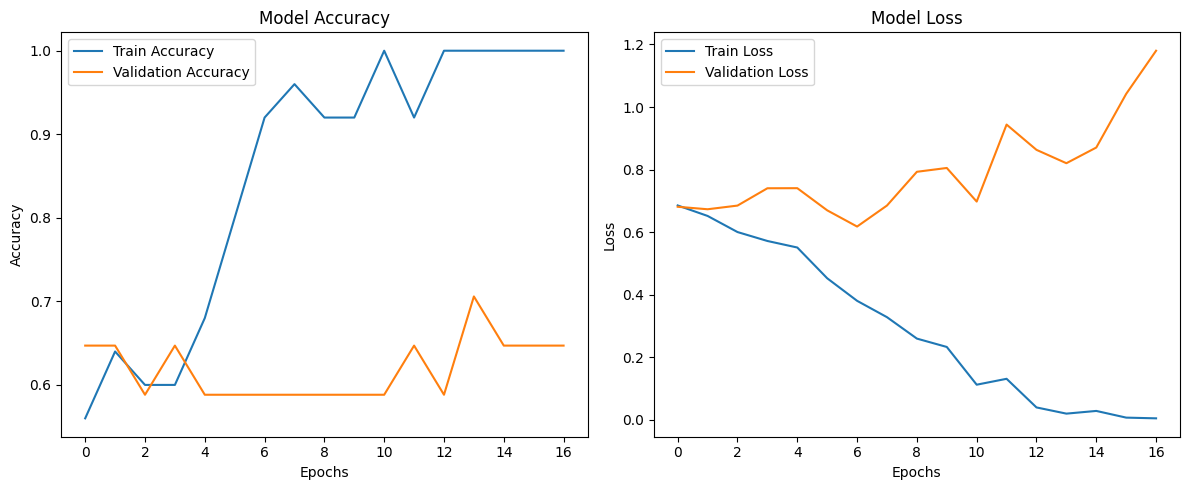

In [ ]:
plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7059 - loss: 0.8204
Test Accuracy: 0.7059, Test Loss: 0.8204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.75      0.67      0.71         9

    accuracy                           0.71        17
   macro avg       0.71      0.71      0.71        17
weighted avg       0.71      0.71      0.71        17



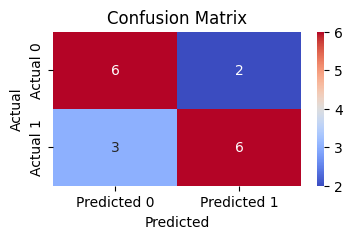

In [ ]:
evaluate_test_predictions(model, [X_timeseries_test, X_categorical_test, X_image_test])

# Saving test data to be used later

In [ ]:
# test_data_path = os.path.join(CECS_698_PATH, 'Test Data', 'Eyetracker and Biomarkers') # Test data including eye tracking and biomarkers
# if not os.path.exists(test_data_path):
#     os.makedirs(test_data_path)
#     print(f"Created {test_data_path}")
# else:
#     print(f"{test_data_path} already exists")

Created /content/drive/MyDrive/CECS 698 - Data Analysis/Test Data/Eyetracker and Biomarkers


In [ ]:
# # Saving
# file = os.path.join(test_data_path, f"X_timeseries_test.pkl")
# with open(file, 'wb') as f:
#     pickle.dump(X_timeseries_test, f)

# file = os.path.join(test_data_path, f"X_categorical_test.pkl")
# with open(file, 'wb') as f:
#     pickle.dump(X_categorical_test, f)

# file = os.path.join(test_data_path, f"X_image_test.pkl")
# with open(file, 'wb') as f:
#     pickle.dump(X_image_test, f)